<a href="https://colab.research.google.com/github/XiangxiangXu/MCR/blob/main/H_nest_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 12
batch_size = 128
fdim = 128 # feature dimension

num_classes = 10


centralize = lambda x: x - torch.mean(x, 0) # zero-mean
cov = lambda x: x.T @ x / (x.size()[0]-1.) # covariance

def neg_hscore(f, g):
    """
    compute the negative h-score
    """
    f0 = centralize(f)
    g0 = centralize(g)
    corr = torch.mean(torch.sum(f0*g0, 1))
    # to generate zero-mean f, g
    cov_f = cov(f)
    cov_g = cov(g)
    return - corr + torch.trace(cov_f @ cov_g) / 2.

def neg_hscore_nest(f, g, dim0 = 0):
    """
    compute the (nagative) nested H-score:

    from dim0
    """
    f_dim = f.shape[1]
    neg_h_nest = torch.sum(torch.stack(
        [neg_hscore(f[:, :i+1], g[:, :i+1])
         for i in range(dim0, f_dim)]))
    return neg_h_nest

def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


def tensor_round(tensor):
    return torch.round(tensor)


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
    # transforms.Lambda(lambda tensor:tensor_round(tensor))
])

train_dataset = MNIST('../mnist_data/', transform=img_transform, download=True)
test_dataset = MNIST('../mnist_data/', train=False, transform=img_transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# fNet: a simple convolutional neural net
class fNet(nn.Module):
    def __init__(self, fdim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc = nn.Linear(9216, fdim)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.dropout(x, p =0.25)
        f = x.flatten(start_dim = 1)
        f = self.fc(f)
        return f        #x.view(-1, x.size(1))

# gNet: fully connected
class gNet(nn.Module):
    def __init__(self, fdim, num_classes):
        super().__init__()
        self.fc = nn.Linear(num_classes, fdim)

    def forward(self, y):
        g = self.fc(y)
        return g

class fgNet(nn.Module):
    def __init__(self, fdim, num_classes):
        super().__init__()
        self.fnet = fNet(fdim)
        self.num_classes = num_classes
        self.gnet = gNet(fdim, num_classes)

    def forward(self, x, y):
        f = self.fnet(x)
        g = self.gnet(y)
        return f, g

    # compute the prediction
    def pred(self, x, py):
        f = self.fnet(x)
        g = self.gnet(torch.eye(self.num_classes))
        pygx = py * (1 + f @ g.T)
        y_pred = torch.argmax(pygx, 1)
        return pygx, y_pred

fg_model = fgNet(fdim, num_classes)
opt = optim.Adadelta(fg_model.parameters())

# compute the prior distribution
py = torch.mean(torch.eye(num_classes)[train_dataset.targets], 0)

for epoch in range(num_epochs):
    for x, y in train_loader:
        y_onehot = torch.eye(num_classes)[y] # one-hot encoding
        f, g = fg_model(x, y_onehot)
        loss = neg_hscore_nest(f, g)

        loss.backward()
        opt.step()
        opt.zero_grad()

    print('training h_score =', neg_hscore_nest(f, g))


training h_score = tensor(-394.2928, grad_fn=<SumBackward0>)
training h_score = tensor(-391.4599, grad_fn=<SumBackward0>)
training h_score = tensor(-411.4750, grad_fn=<SumBackward0>)
training h_score = tensor(-440.2928, grad_fn=<SumBackward0>)
training h_score = tensor(-446.4135, grad_fn=<SumBackward0>)
training h_score = tensor(-436.1521, grad_fn=<SumBackward0>)
training h_score = tensor(-435.0119, grad_fn=<SumBackward0>)
training h_score = tensor(-459.7469, grad_fn=<SumBackward0>)
training h_score = tensor(-430.8616, grad_fn=<SumBackward0>)
training h_score = tensor(-428.6935, grad_fn=<SumBackward0>)
training h_score = tensor(-439.4484, grad_fn=<SumBackward0>)
training h_score = tensor(-459.1401, grad_fn=<SumBackward0>)
test_hscore = tensor(-3.8267) | acc =  tensor(0.9922)
test_hscore = tensor(-3.7292) | acc =  tensor(0.9922)
test_hscore = tensor(-3.6437) | acc =  tensor(0.9688)
test_hscore = tensor(-3.7057) | acc =  tensor(0.9922)
test_hscore = tensor(-3.4541) | acc =  tensor(0.9922

In [ ]:

# Test
cnt_total = 0
cnt_correct = 0
var_f = 0
var_g = 0
f_long = []
g_long = []
y_long = []
with torch.no_grad():
    for x, y in test_loader:
        y_onehot = torch.eye(num_classes)[y] # one-hot encoding
        f, g = fg_model(x, y_onehot)
        if len(f_long) == 0:
            f_long = f
            g_long = g
            y_long = y
        else:
            f_long = torch.cat((f_long, f), 0)
            g_long = torch.cat((g_long, g), 0)
            y_long = torch.cat((y_long, y), 0)
        pygx, y_pred = fg_model.pred(x, py)
        acc = (y_pred == y).sum() / float(y.size(0)) # accuracy
        var_f += torch.var(f, axis = 0) * float(y.size(0))
        var_g += torch.var(g, axis = 0) * float(y.size(0))
        cnt_total += float(y.size(0))
        cnt_correct += (y_pred == y).sum()
        print('test_hscore =', neg_hscore_nest(f, g), '| acc = ', acc)
test_acc = cnt_correct / cnt_total
var_f = var_f / cnt_total
var_g = var_g / cnt_total
print(test_acc)

test_hscore = tensor(-425.6562) | acc =  tensor(0.9844)
test_hscore = tensor(-430.9233) | acc =  tensor(0.9844)
test_hscore = tensor(-426.5316) | acc =  tensor(0.9688)
test_hscore = tensor(-462.3169) | acc =  tensor(1.)
test_hscore = tensor(-453.5765) | acc =  tensor(0.9766)
test_hscore = tensor(-448.9976) | acc =  tensor(0.9688)
test_hscore = tensor(-457.3233) | acc =  tensor(0.9766)
test_hscore = tensor(-451.8482) | acc =  tensor(0.9922)
test_hscore = tensor(-436.3925) | acc =  tensor(1.)
test_hscore = tensor(-449.3908) | acc =  tensor(1.)
test_hscore = tensor(-432.8439) | acc =  tensor(0.9922)
test_hscore = tensor(-464.9178) | acc =  tensor(1.)
test_hscore = tensor(-457.8498) | acc =  tensor(1.)
test_hscore = tensor(-465.4703) | acc =  tensor(0.9844)
test_hscore = tensor(-451.5815) | acc =  tensor(0.9766)
test_hscore = tensor(-460.7654) | acc =  tensor(0.9922)
test_hscore = tensor(-410.5612) | acc =  tensor(0.9766)
test_hscore = tensor(-429.3703) | acc =  tensor(0.9922)
test_hscore 

<StemContainer object of 3 artists>

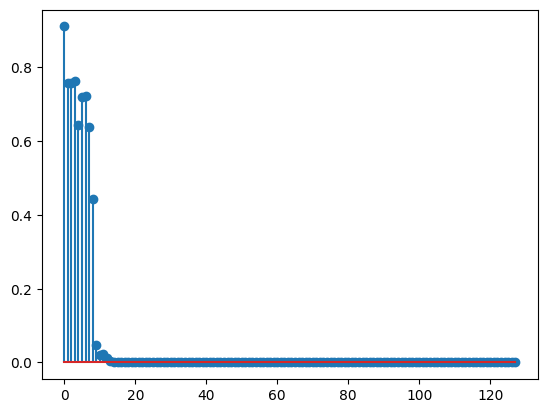

In [ ]:
spec = var_f * var_g
import matplotlib.pyplot as plt
plt.stem(spec)

In [ ]:
y_long = y_long.numpy()

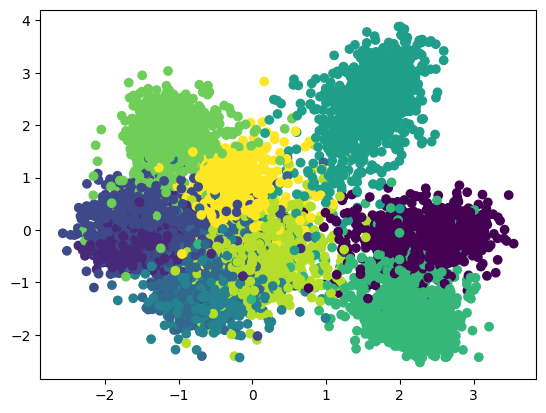

In [ ]:
dim = 3
plt.scatter(f_long[:, 0], f_long[:, dim], c = y_long)
